**Table of contents**<a id='toc0_'></a>    
- [Prophet Model](#toc1_1_)    
    - [Prophet Tuned Model](#toc1_1_1_)    
    - [Facebook Prophet Analysis](#toc1_1_2_)    
      - [Preparing Data for Prophet](#toc1_1_2_1_)    
    - [Recurrent Neural Networks (RNNs)](#toc1_1_3_)    
      - [Data Preprocessing for RNNs](#toc1_1_3_1_)    
      - [Building and Training the RNN](#toc1_1_3_2_)    
      - [Predictions and Evaluation](#toc1_1_3_3_)    
- [Code of the dead](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Prophet Model](#toc0_)
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [32]:
from capstone_functions import *
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

# Set the random.seed(42)
np.random.seed(42)


In [33]:
from prophet.plot import plot_cross_validation_metric, plot_plotly
import statsmodels.api as sm
from prophet.serialize import model_to_json, model_from_json
from prophet.diagnostics import cross_validation, performance_metrics
import scipy.stats as stats

In [34]:
master_df = pd.read_parquet("../Data/master_df.parquet")

#prepare the data for prophet
master_df = master_df.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}).copy()

# sns.set_style('538')
master_df.info()
master_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 67 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ds                                    1131 non-null   datetime64[ns]
 1   y                                     1131 non-null   int32         
 2   new_fatal                             1131 non-null   int32         
 3   confirmed                             1131 non-null   int32         
 4   fatal                                 1131 non-null   int32         
 5   infected                              1131 non-null   int32         
 6   new_recovered                         1131 non-null   int32         
 7   recovered                             1131 non-null   int32         
 8   total_removed                         1131 non-null   int32         
 9   new_hospitalized_patients             944 non-null    float32       
 10  

,ds,y,new_fatal,confirmed,fatal,infected,new_recovered,recovered,total_removed,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,average_temperature_celsius,cancel_events,cumulative_hospitalized_patients,derived_reproduction_rate,dew_point,excess_mortality,excess_mortality_cumulative,excess_mortality_cumulative_absolute,facial_coverings,gatherings_restrictions,information_campaigns,internal_movement_restrictions,international_movement_restrictions,...,rho_transmission_rate,school_closing,sig_recovery_rate,snowfall_mm,stay_home_restrictions,stringency_index,susceptible,t/k_mortality_period,t/r_infection_period,t/s_recovery_period,testing_policy,tests_per_case,total_boosters,total_tests,total_vaccinations,transport_closing,vaccination_policy,workplace_closing,dayofweek,quarter,month,year,dayofyear,dayofmonth,new_bi_weekly_vaccinations
0,2020-02-15,0,0,15,0,15,0,0,0,0.0,0.0,0.0,0.956790,0.0,0.0,35.466824,-6.882716,-2.363827,-3.049970,-12854.276367,0.0,0.0,0.0,0.0,3.0,...,0.008729,0.0,0.000097,0.0,0.0,8.33,326687488.0,279.384735,4.773121,429.58667,1.0,9.3,0.0,139.5,0.0,0.0,0.0,0.0,5,1,2,2020,46,15,0.0
1,2020-02-16,0,0,15,0,15,0,0,0,0.0,0.0,0.0,3.919753,0.0,0.0,34.655106,-5.919753,-2.360000,-3.030000,-13024.399414,0.0,0.0,0.0,0.0,3.0,...,0.008742,0.0,0.000097,0.0,0.0,8.33,326687488.0,268.378815,4.766480,429.58667,1.0,9.3,0.0,279.0,0.0,0.0,0.0,0.0,6,1,2,2020,47,16,0.0
2,2020-02-17,10,0,25,0,25,0,0,0,0.0,0.0,0.0,6.197531,0.0,0.0,33.889042,-0.481481,-2.294236,-3.005807,-13172.550781,0.0,0.0,0.0,0.0,3.0,...,0.008749,0.0,0.000097,0.0,0.0,8.33,326687488.0,258.510406,4.762334,429.58667,1.0,9.3,0.0,511.5,0.0,0.0,0.0,0.0,0,1,2,2020,48,17,0.0
3,2020-02-18,0,0,25,0,25,0,0,0,0.0,0.0,0.0,0.592593,0.0,0.0,33.163906,-5.759259,-2.166535,-2.977392,-13298.730469,0.0,0.0,0.0,0.0,3.0,...,0.008752,0.0,0.000097,0.0,0.0,8.33,326687488.0,249.624802,4.760667,429.58667,1.0,9.3,0.0,744.0,0.0,0.0,0.0,0.0,1,1,2,2020,49,18,0.0
4,2020-02-19,0,0,25,0,25,0,0,0,0.0,0.0,0.0,-2.753086,0.0,0.0,32.475555,-7.364198,-1.976897,-2.944754,-13402.938477,0.0,0.0,0.0,0.0,3.0,...,0.008751,0.0,0.000097,0.0,0.0,8.33,326687488.0,241.594635,4.761477,429.58667,1.0,9.3,0.0,976.5,0.0,0.0,0.0,0.0,2,1,2,2020,50,19,0.0


In [35]:
no_null_rows = master_df.dropna().copy()

no_null_col = master_df.dropna(axis=1).copy()

cutoff=28
cutoff_date = no_null_col.ds.max() - pd.Timedelta(days=cutoff)

train_df = no_null_col[no_null_col.ds < cutoff_date].copy()
test_df = no_null_col[no_null_col.ds >= cutoff_date].copy()


In [36]:
y_train = train_df[['ds','y']].copy()
y_test = test_df[['ds','y']].copy()


most_important = ['stringency_index', 'derived_reproduction_rate', 'new_bi_weekly_vaccinations', 
                'current_hospitalized_patients',  'excess_mortality', 'month', 'ds']

X_train = train_df[most_important].copy()
X_test = test_df[most_important].copy()

val_eval_holder = pd.DataFrame().rename_axis('Validation Metric', axis=1)
in_sample_eval_holder = pd.DataFrame().rename_axis('In-Sample Metric', axis=1)
out_of_sample_eval_holder = pd.DataFrame().rename_axis('Out-of-Sample Metric', axis=1)


## Base Model of Prophet

In [37]:
def residual_plotter(forecast_df, yhat_col='yhat', original_col='y_train'):
    """
    Plots residual diagnostics and returns evaluation metrics for a forecast dataframe from Prophet.
    
    Parameters:
    - forecast_df: DataFrame from Prophet prediction.
    
    Returns:
    - scores: Series with R2, MAE, RMSE, and SMAPE scores.
    """
    
    # Calculate residuals and lags
    residuals = (forecast_df[original_col] - forecast_df[yhat_col]).dropna()
    lags = int(min(20, round(len(residuals)/3) - 1))
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Histogram
    sns.histplot(residuals, kde=True,  ax=ax[0,0])
    ax[0,0].set_title("Histogram of Residuals")
    ax[0,0].set_xlabel("Residual")
    ax[0,0].set_ylabel("Frequency")
    ax[0,0].grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=ax[0,1])
    ax[0,1].set_title("Q-Q Plot of Residuals")
    ax[0,1].grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # ACF and PACF plots
    sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=ax[1,0])
    sm.graphics.tsa.plot_pacf(residuals, lags=lags, ax=ax[1,1])
    
    ax[1,0].set_title("ACF of Residuals")
    ax[1,1].set_title("PACF of Residuals")
    plt.tight_layout()
    plt.show()
    
        
    # Evaluation Metrics
    r2 = r2_score(forecast_df[original_col], forecast_df[yhat_col])
    mae = mean_absolute_error(forecast_df[original_col], forecast_df[yhat_col])
    rmse = mean_squared_error(forecast_df[original_col], forecast_df[yhat_col], squared=False)
    smape_score = smape(forecast_df[original_col], forecast_df[yhat_col])
    
    scores = pd.Series({
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'SMAPE': smape_score
    })
    
    return scores #, residuals

# residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')
# residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


In [38]:
def forecast_df_complete(model, y_train, y_test):

    prophet_model_df = model.make_future_dataframe(cutoff, freq='D', include_history=True)
    forecast_df = model.predict(prophet_model_df)
    forecast_df = forecast_df.merge(y_train, on='ds', how='left').copy()
    forecast_df = forecast_df.merge(y_test, on='ds', how='left', suffixes = ['_train', '_test']).copy()
    
    return forecast_df

In [39]:

model = Prophet().fit(y_train)


forecast_df = forecast_df_complete(model, y_train, y_test)


# Generate the Prophet forecast plot
fig = plot_plotly(model, forecast_df)

# Add the test actual data points
fig.add_trace(go.Scatter(
    x=y_test.ds, 
    y=y_test.y, 
    mode='lines', 
    name='Historical Predictions', 
    line=dict(color='green')
))

# Add titles and labels
fig.update_layout(
    title="Prophet Model Forecast vs Actual Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Legend"
)

# Display the plot
fig.show();


19:02:19 - cmdstanpy - INFO - Chain [1] start processing
19:02:20 - cmdstanpy - INFO - Chain [1] done processing


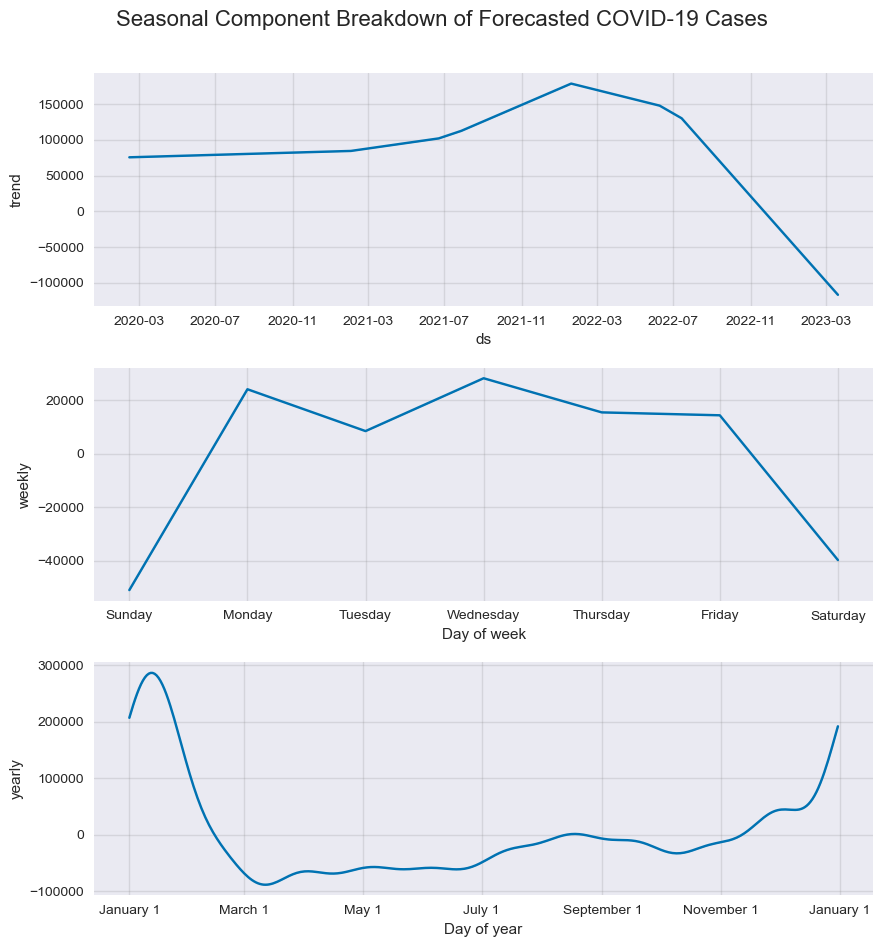

In [40]:

fig = model.plot_components(forecast_df)
fig.suptitle('Seasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
fig.show();
# Using the function on the sample dataframe


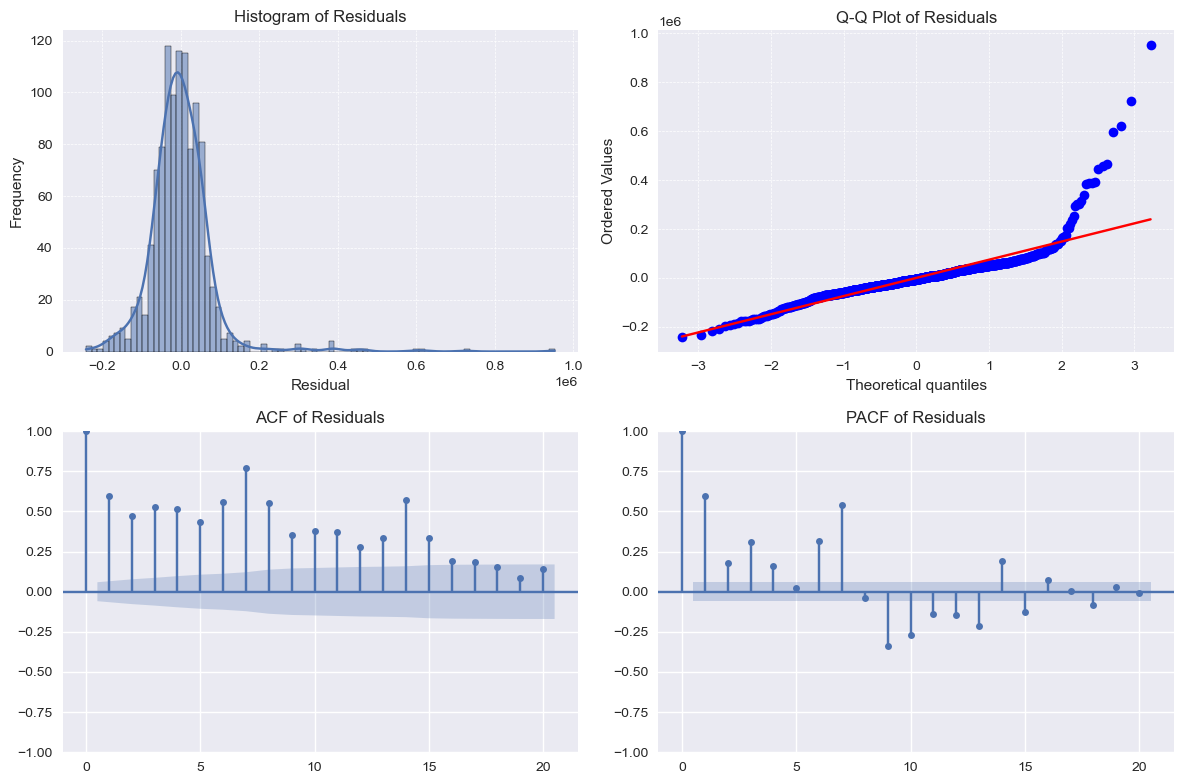

In [41]:

in_sample_eval_holder['Base Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')


In [42]:
val_eval_holder

Validation Metric


In [43]:

df_cv = cross_validation(
    model, 
    initial=f"200 days", 
    period=f"29 days", 
    horizon=f"29 days",
    parallel="processes")

val_eval_holder['Base Prophet Model'] = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))

plot_cross_validation_metric(df_cv, metric='rmse')

plt.title('RMSE for COVID-19 Forecasting using Prophet');


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


KeyboardInterrupt: 

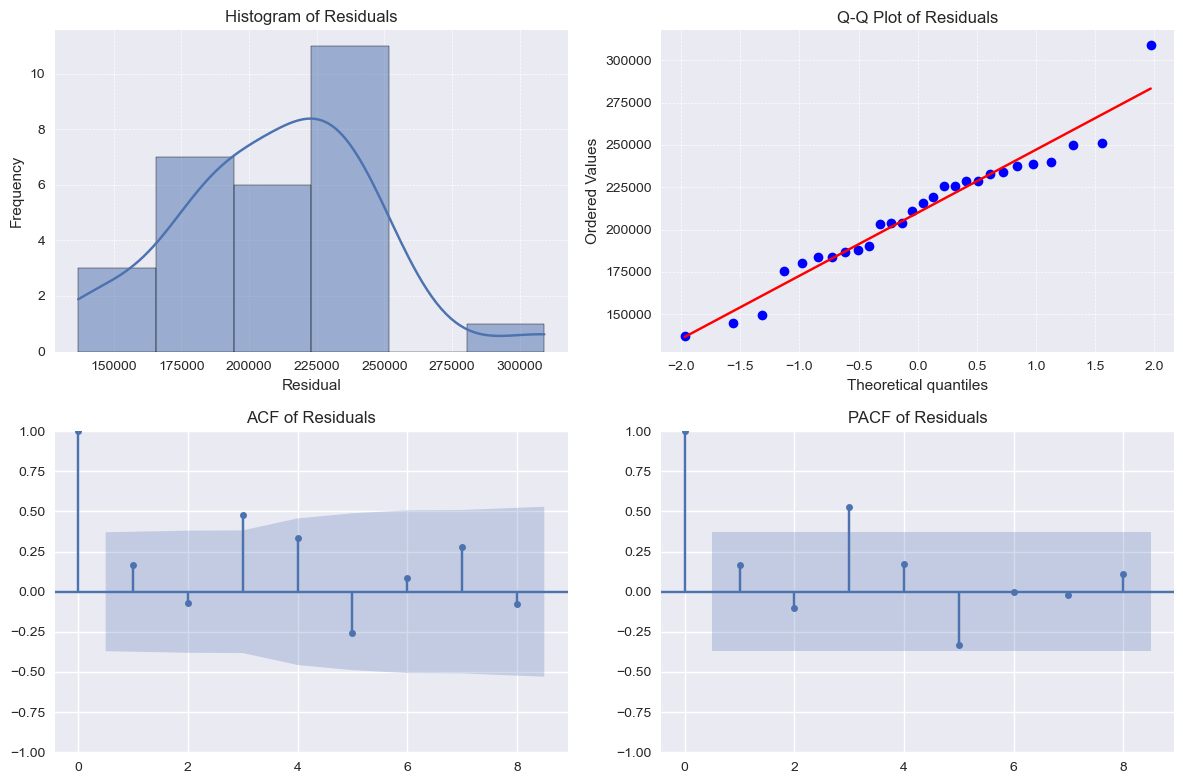

In [ ]:


out_of_sample_eval_holder['Base Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


# with open('serialized_model.json', 'w') as fout:
#     fout.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as fin:
#     model = model_from_json(fin.read())  # Load model


In [ ]:
display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

Validation Metric,Base Prophet Model
mse,16966188168.792055
rmse,128001.939642
mae,82931.093656
mdape,0.617823
smape,0.745998
coverage,0.450405


In-Sample Metric,Base Prophet Model
R2,0.574955
MAE,52007.451003
RMSE,84706.706549
SMAPE,74.545866


### <a id='toc1_1_1_'></a>[Prophet Tuned Model](#toc0_)

In [ ]:
brute_force = False

In [ ]:
if brute_force:
    # Python
    import itertools

    param_grid = {  
        'changepoint_prior_scale': np.logspace(-2.5,-1.5, 5),
        'seasonality_prior_scale': np.logspace(-1.5,1, 5),
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here
    mae = []
    smape = []
    coverage = []


    # Use cross validation to evaluate all parameters
    for params in all_params:    
        m = Prophet(**params).fit(y_train)  # Fit model with given params
        
        df_cv = cross_validation(
            m, 
            initial=f"200 days", 
            period=f"29 days", 
            horizon=f"29 days",
            parallel="processes")

        
        df_p = performance_metrics(df_cv, rolling_window=29)
        rmses.append(df_p['rmse'].values[0])
        mae.append(df_p['mae'].values[0])
        smape.append(df_p['smape'].values[0])
        coverage.append(df_p['coverage'].values[0])
        
    # Find the best parameters

    tuning_results1 = pd.DataFrame(all_params)
    tuning_results1['rmse'] = rmses
    tuning_results1['mae'] = mae
    tuning_results1['smape'] = smape
    tuning_results1['coverage'] = coverage


In [ ]:
if brute_force:
    best_params = all_params[np.argmin(rmses)]
    print(best_params)


    tuning_results1['compo'] = (tuning_results['rmse'] + tuning_results1['mae']) * tuning_results1['smape']

    tuning_results1.sort_values(by='changepoint_prior_scale').style.background_gradient(cmap='coolwarm', subset=['smape','mae', 'rmse', 'compo'])

In [ ]:
if brute_force:
    param_grid = {  
        'changepoint_prior_scale': np.logspace(-2, -1, 7),
        'seasonality_prior_scale': np.logspace(-2, 2, 7),
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here
    mae = []
    smape = []
    coverage = []

    # Use cross validation to evaluate all parameters
    for params in all_params:    
        m = Prophet(**params).fit(y_train)  # Fit model with given params
        
        df_cv = cross_validation(
            m, 
            initial=f"200 days", 
            period=f"29 days", 
            horizon=f"29 days",
            parallel="processes")

        df_p = performance_metrics(df_cv, rolling_window=29)
        rmses.append(df_p['rmse'].values[0])
        mae.append(df_p['mae'].values[0])
        smape.append(df_p['smape'].values[0])
        coverage.append(df_p['coverage'].values[0])

    # Find the best parameters

    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    tuning_results['mae'] = mae
    tuning_results['smape'] = smape
    tuning_results['coverage'] = coverage



In [ ]:
if brute_force:
    best_params = all_params[np.argmin(rmses)]
    print(best_params)


    tuning_results['compo'] = ((tuning_results['rmse'] + tuning_results['mae']) / 2) / y_train.std()[1]
    tuning_results['compo2'] = (tuning_results['rmse'] + tuning_results['mae']) * tuning_results['smape'] / y_train.std()[1]

    tuning_results.sort_values(by='compo').head(15).style.background_gradient(cmap='coolwarm', subset=['smape','mae', 'rmse', 'compo', 'compo2'])


In [ ]:

model2 = Prophet(changepoint_prior_scale = 0.031623, seasonality_prior_scale = 0.046416).fit(y_train)

# changepoint_prior_scale = 0.031623
# seasonality_prior_scale = 0.046416

forecast_df = forecast_df_complete(model2, y_train, y_test)


# Generate the Prophet forecast plot
fig = plot_plotly(model2, forecast_df)

# Add the test actual data points
fig.add_trace(go.Scatter(
    x=y_test.ds, 
    y=y_test.y, 
    mode='lines', 
    name='Historical Predictions', 
    line=dict(color='green')
))

# Add titles and labels
fig.update_layout(
    title="Tuned Prophet Model Forecast vs Actual Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Legend"
)

# Display the plot
fig.show();


19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1] done processing


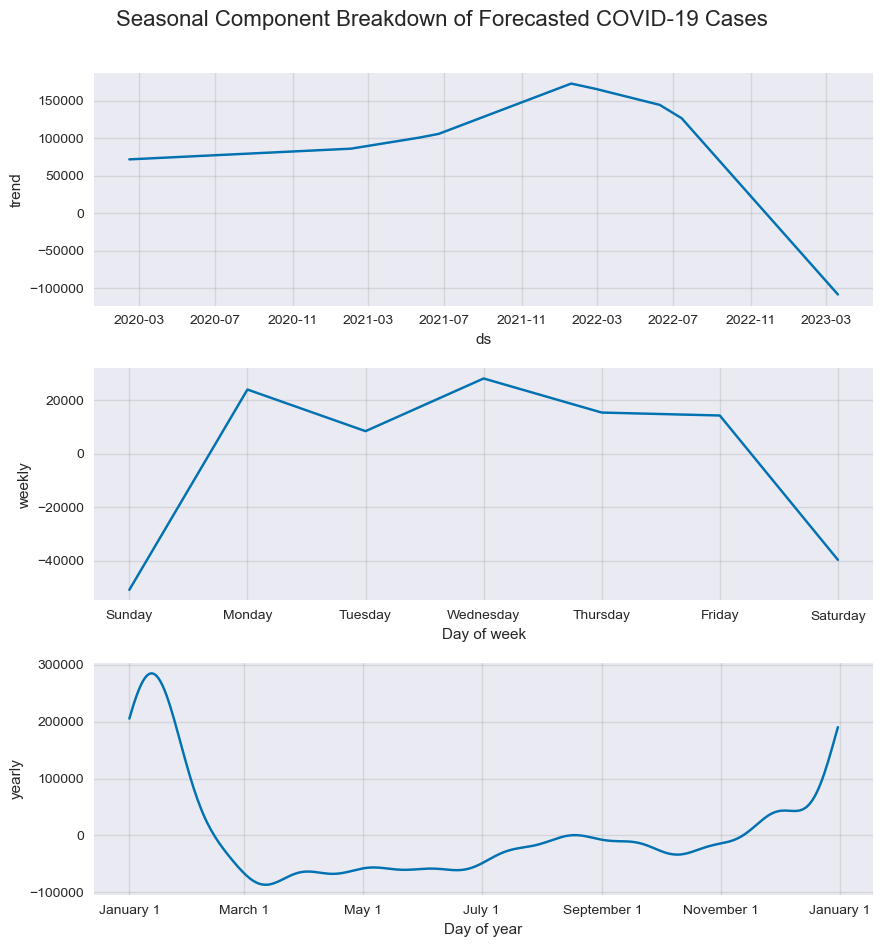

In [ ]:

fig = model2.plot_components(forecast_df)
fig.suptitle('Seasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
fig.show();
# Using the function on the sample dataframe


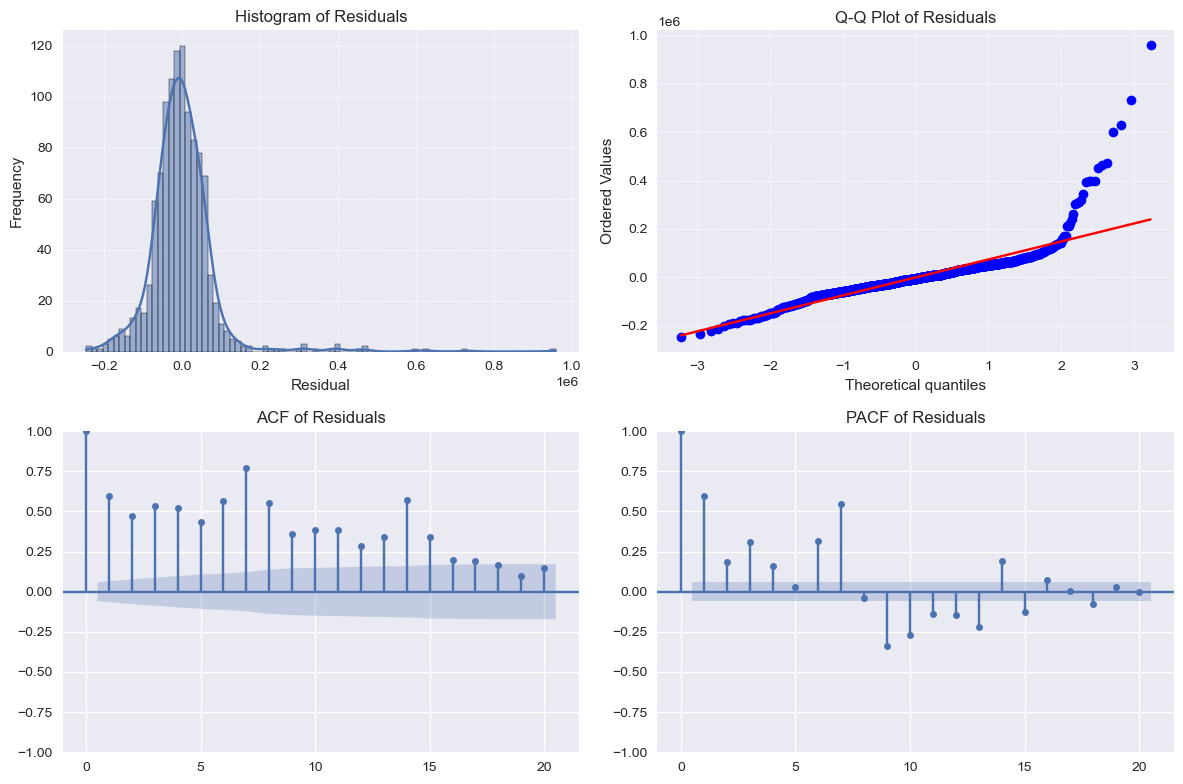

In [ ]:

in_sample_eval_holder['Tuned Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


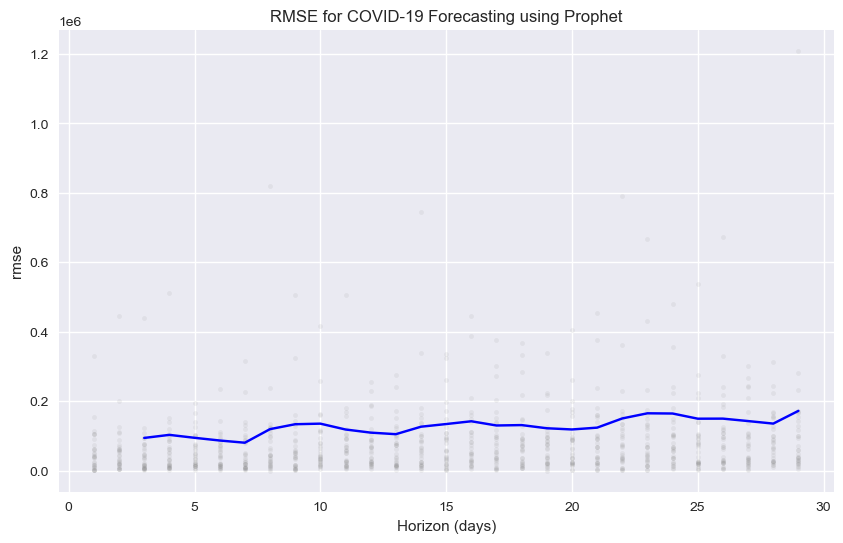

In [ ]:

df_cv = cross_validation(
    model2, 
    initial=f"200 days", 
    period=f"29 days", 
    horizon=f"29 days",
    parallel="processes")

val_eval_holder['Tuned Prophet Model'] = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))

plot_cross_validation_metric(df_cv, metric='rmse')

plt.title('RMSE for COVID-19 Forecasting using Prophet');


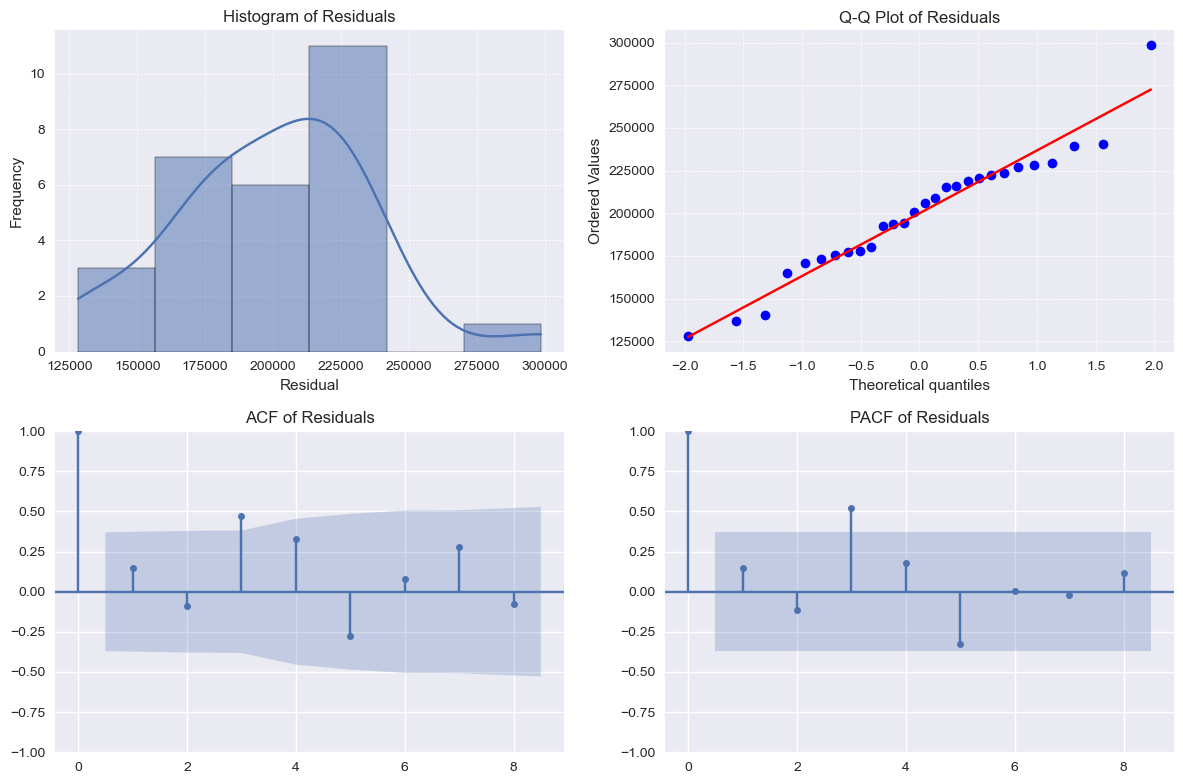

In [ ]:


out_of_sample_eval_holder['Tuned Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


# with open('serialized_model.json', 'w') as fout:
#     fout.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as fin:
#     model = model_from_json(fin.read())  # Load model


In [ ]:
display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

Validation Metric,Base Prophet Model,Tuned Prophet Model
mse,16966188168.792055,16841478633.085014
rmse,128001.939642,127657.946494
mae,82931.093656,82130.781146
mdape,0.617823,0.623280
smape,0.745998,0.743553
coverage,0.450405,0.457573


In-Sample Metric,Base Prophet Model,Tuned Prophet Model
R2,0.574955,0.571397
MAE,52007.451003,51681.809473
RMSE,84706.706549,85060.548056
SMAPE,74.545866,73.461095



### <a id='toc1_1_2_'></a>[Facebook Prophet Analysis](#toc0_)

Facebook Prophet is designed for forecasting time series data. Let's see how we can use it.


In [ ]:
exog_train = pd.merge(X_train, y_train, on = ['ds']).drop('month', axis=1)

exog_test = pd.merge(X_test, y_test, on = ['ds']).drop('month', axis=1)


In [ ]:
model3 = Prophet(changepoint_prior_scale = 0.031623, seasonality_prior_scale = 0.046416)

for i in X_train.columns[:-2]:
    model3.add_regressor(i, prior_scale=0.5, mode='additive')

model3.fit(exog_train)



19:01:41 - cmdstanpy - INFO - Chain [1] start processing
19:01:41 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:

forecast_df = forecast_df_complete(model3, y_train, y_test)


# Generate the Prophet forecast plot
fig = plot_plotly(model3, forecast_df)

# Add the test actual data points
fig.add_trace(go.Scatter(
    x=y_test.ds, 
    y=y_test.y, 
    mode='lines', 
    name='Historical Predictions', 
    line=dict(color='green')
))

# Add titles and labels
fig.update_layout(
    title="Prophet Tuned and Exogenous Model Forecast vs Actual Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Legend"
)

# Display the plot
fig.show();


ValueError: Regressor 'stringency_index' missing from dataframe

In [ ]:

fig = model3.plot_components(forecast_df)
fig.suptitle('Seasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
fig.show();



In [ ]:

# Using the function on the sample dataframe

in_sample_eval_holder['Tuned and Exogenous Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train')



In [ ]:

df_cv = cross_validation(
    model3, 
    initial=f"200 days", 
    period=f"29 days", 
    horizon=f"29 days",
    parallel="processes")

val_eval_holder['Tuned and Exogenous Prophet Model'] = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))

plot_cross_validation_metric(df_cv, metric='rmse')

plt.title('RMSE for COVID-19 Forecasting using Tuned and Exogenous Prophet Model');



In [ ]:

out_of_sample_eval_holder['Tuned and Exogenous Prophet Model'] = residual_plotter(forecast_df.dropna(subset='y_test'), yhat_col='yhat', original_col='y_test')


# with open('serialized_model.json', 'w') as fout:
#     fout.write(model_to_json(model3))  # Save model3

# with open('serialized_model.json', 'r') as fin:
#     model3 = model_from_json(fin.read())  # Load model3



#### <a id='toc1_1_2_1_'></a>[Preparing Data for Prophet](#toc0_)

Prophet requires the dataset to have two columns: `ds` and `y`, where `ds` is the timestamp and `y` is the value we want to predict.



### <a id='toc1_1_3_'></a>[Recurrent Neural Networks (RNNs)](#toc0_)

RNNs are suitable for time series prediction due to their ability to recognize patterns in sequences of data.



#### <a id='toc1_1_3_1_'></a>[Data Preprocessing for RNNs](#toc0_)


In [ ]:


from sklearn.preprocessing import MinMaxScaler

data = train_df['new_confirmed'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for training
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])




#### <a id='toc1_1_3_2_'></a>[Building and Training the RNN](#toc0_)


In [ ]:


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)




#### <a id='toc1_1_3_3_'></a>[Predictions and Evaluation](#toc0_)


In [ ]:


scaled_predictions = model.predict(X_test)
predictions = scaler.inverse_transform(scaled_predictions)




---

This outline gives a clear walkthrough of the different steps involved in each method. Depending on the specific details of your dataset and the problem at hand, you might need to adjust and fine-tune some of these steps.

# <a id='toc2_'></a>[Code of the dead](#toc0_)

In [ ]:
# # estimators = [('scaler', None),
# #             ('feature_selection', None),
# #             ('dim_reducer', None),
# #             ('model', ARIMA())]

# # pipe = Pipeline(estimators) #, memory=cachedir

# # param_grid = {
# #     'model__p': list(range(16)),
# #     'model__d': list(range(3)),
# #     'model__q': list(range(16))
# # }

# # # 4. Split the dataset using TimeSeriesSplit
# # tscv = TimeSeriesSplit(n_splits=5)

# # # 5. Set up and run the GridSearchCV
# # gsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_grid, verbose=1, n_jobs=-1)
# # gsearch.fit(train_df.index.values.reshape(-1, 1), train_df['new_confirmed'])

# # print(gsearch.best_params_)


# # best_score, best_cfg = float("inf"), None

# # GridSearchCV
# # for train_index, validation_index in tscv.split(train_df['new_confirmed']):
# #     train, test = train_df['new_confirmed'].iloc[train_index], train_df['new_confirmed'].iloc[validation_index]

# #     try:
# #         model = pm.auto_arima(train, start_p=1, start_q=1,
# #                         test='adf',       # use adftest to find optimal 'd'
# #                         max_p=15, max_q=3, # maximum p and q
# #                         m=1,              # frequency of series
# #                         d=None,           # let model determine 'd'
# #                         seasonal=False,   # No Seasonality
# #                         start_P=0, 
# #                         D=0, 
# #                         trace=True,
# #                         error_action='ignore',  
# #                         suppress_warnings=True, 
# #                         stepwise=True, 
# #                         stationary=True,
# #                         n_jobs=-1)
# #     except:
# #         continue
# #     predictions = model.predict(n_periods=len(test))
# #     mse = mean_squared_error(test, predictions)
    
# #     if mse < best_score:
# #         best_score, best_cfg = mse, (model.order, model.seasonal_order)
# #         best_model = model

# # print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
# # best_model.summary()

# # gsearch = GridSearchCV(estimator=model, cv=tscv,
# #                         param_grid=param_search)
# # gsearch.fit(X, y)


# tscv = TimeSeriesSplit(n_splits=5)

# for train_index, validation_index in tscv.split(series['Confirmed']):


# model = pm.auto_arima(y= test_df['new_confirmed'], start_p=1, start_q=1,
#                     ['new_confirmed'], start_p=1, start_q=1,
#                     test='adf',       # use adftest to find optimal 'd'
#                     max_p=20, max_q=5, # maximum p and q
#                     m=1,              # frequency of series
#                     d=None,           # let model determine 'd'
#                     seasonal=False,   # No Seasonality
#                     start_P=0, 
#                     D=0, 
#                     trace=True,
#                     error_action='ignore',  
#                     suppress_warnings=True, 
#                     stepwise=True)

# print(model.summary())

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# import numpy as np
# X = np.array([[4, 5, 6, 1, 0, 2], [3.1, 3.5, 1.0, 2.1, 8.3, 1.1]]).T
# y = np.array([1, 6, 7, 1, 2, 3])

# model = ARIMA()
# param_search = {'max_depth' : [3, 5]}

# tscv = TimeSeriesSplit(n_splits=2)
# gsearch = GridSearchCV(estimator=model, cv=tscv,
#                         param_grid=param_search)
# gsearch.fit(X, y)

In [ ]:
# from statsmodels.tsa.x13 import x13_arima_analysis
# result = x13_arima_analysis(df['your_column_name'])
# print(result.seasadj)  # Seasonally adjusted series

# # Performing seasonal decomposition on 'new_confirmed' column
# decomposition = tsa.seasonal_decompose(train_df['current_hospitalized_patients'], model='additive', period=7)

# # Adding the decomposition data to the dataframe
# train_df["Hosp_Trend"] = decomposition.trend
# train_df["Hosp_Seasonal"] = decomposition.seasonal
# train_df["Hosp_Residual"] = decomposition.resid


# # Creating subplots for the trend, seasonal, and residual components
# cols = ["Hosp_Trend", "Hosp_Seasonal", "Hosp_Residual"]
# fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

# for i, col in enumerate(cols):
#     fig.add_trace(go.Scatter(x=train_df.index, y=train_df[col], name=col), row=i+1, col=1)

# fig.update_layout(height=800, width=1200, title='Seasonal Decomposition of Hospitalized Patients')
# fig.show()

# # Performing seasonal decomposition on 'new_confirmed' column
# decomposition = tsa.seasonal_decompose(train_df['new_fatal'], model='additive', period=12)

# # Adding the decomposition data to the dataframe
# train_df["Fatal_Trend"] = decomposition.trend
# train_df["Fatal_Seasonal"] = decomposition.seasonal
# train_df["Fatal_Residual"] = decomposition.resid


# # Creating subplots for the trend, seasonal, and residual components
# cols = ["Fatal_Trend", "Fatal_Seasonal", "Fatal_Residual"]
# fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

# for i, col in enumerate(cols):
#     fig.add_trace(go.Scatter(x=train_df.index, y=train_df[col], name=col), row=i+1, col=1)

# fig.update_layout(height=800, width=1200, title='Seasonal Decomposition of Daily Fatalities')
# fig.show()


In [ ]:

# # Create a plot
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot MAPE as an area plot
# sns.lineplot(data=scores, x=scores.index, y='mape', ax=ax1, label='MAPE', alpha=0.5)
# ax1.fill_between(scores.index, 0, scores['mape'], alpha=0.5)

# # Create a second y-axis for RMSE and MAE
# ax2 = ax1.twinx()

# # Plot RMSE on the second y-axis
# sns.lineplot(data=scores, x=scores.index, y='rmse', ax=ax2, label='RMSE', color='red', linewidth=2)

# # Plot MAE on the second y-axis
# sns.lineplot(data=scores, x=scores.index, y='mae', ax=ax2, label='MAE', color='blue', linestyle='--', linewidth=2)

# # Set title, labels and legend
# ax1.set_title('Model Evaluation Metrics')
# ax1.set_xlabel('Metrics')
# ax1.set_ylabel('MAPE (Percentage of Error)')
# ax2.set_ylabel('RMSE / MAE (Cases Incorrectly Predicted)')

# # Format y-axes
# ax1.yaxis.set_major_formatter(PercentFormatter(100.0))
# ax2.yaxis.set_major_formatter(FuncFormatter(comma_format))

# # Display the legend
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Show the plot
# plt.tight_layout()
# plt.show()


In [ ]:
# # # Even though we have a dedicated train/test split, we can (and should) still
# # # use cross-validation on our training set to get a good estimate of the model
# # # performance. We can choose which model is better based on how it performs
# # # over various folds.
# # model1 = pm.arima.ARIMA(order=(2, 1, 1), freq= 'D', suppress_warnings=True)
# # model2 = pm.arima.ARIMA(order=(1, 1, 2),
# #                 seasonal_order=(0, 1, 1, 12),
# #                 freq= 'D',
# #                 suppress_warnings=True)

# # cv = pm.model_selection.SlidingWindowForecastCV(window_size=300, step=200, h=30)

# # model1_cv_scores = pm.model_selection.cross_val_score(
# #     model1, train_df['confirmed'], scoring='smape', cv=cv, verbose=2)

# # model2_cv_scores = pm.model_selection.cross_val_score(
# #     model2, train_df['confirmed'], scoring='smape', cv=cv, verbose=2)

# # print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
# # print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))

# # # Pick based on which has a lower mean error rate
# # m1_average_error = np.average(model1_cv_scores)
# # m2_average_error = np.average(model2_cv_scores)
# # errors = [m1_average_error, m2_average_error]
# # models = [model1, model2]

# # # print out the answer
# # better_index = np.argmin(errors)  # type: int
# # print("Lowest average SMAPE: {} (model{})".format(
# #     errors[better_index], better_index + 1))
# # print("Best model: {}".format(models[better_index]))
# import itertools

# p = d = q = range(0,3)

# pdq = list(itertools.product(p,d,q))

# pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

# ans = []

# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(train_df,
#                                         order=comb,
#                                         seasonal_order=combs,
#                                         freq='D')
#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        
#         except:
#             continue


# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# # # Capture the current time to measure the time taken by the grid search
# # start_time = time.time()

# # # Define a GridSearchCV object with the pipeline, parameter grid, and desired settings
# # grid = GridSearchCV(pipe, param_grid, return_train_score=True, 
# #                     cv=3, refit=True, verbose=1, n_jobs=-1, scoring=scoring_metric)


# # tss = TimeSeriesSplit(n_splits=5)

# # grid_search = GridSearchCV(pipe, grid, cv=tss, scoring='neg_mean_squared_error', verbose=1)
# # grid_search.fit(X, y)

# # best_model = grid_search.best_estimator_
# # best_rmse = np.sqrt(-grid_search.best_score_)

# # tss = TimeSeriesSplit(n_splits=5)
# # df = df.sort_index()



# # fold = 0
# # preds = []
# # scores = []
# # for train_idx, val_idx in tss.split(df):
# #         train = df.iloc[train_idx]
# #         test = df.iloc[val_idx]

# #         train = create_features(train)
# #         test = create_features(test)

# #         FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
# #                         'lag1','lag2','lag3']
# #         TARGET = 'PJME_MW'

# #         X_train = train[FEATURES]
# #         y_train = train[TARGET]

# #         X_test = test[FEATURES]
# #         y_test = test[TARGET]

# #         reg = CatBoostRegressor()
# #         reg.fit(X_train, y_train,
# #                 eval_set=[(X_train, y_train), (X_test, y_test)],
# #                 verbose=100)

# #         y_pred = reg.predict(X_test)
# #         preds.append(y_pred)
# #         score = np.sqrt(mean_squared_error(y_test, y_pred))
# #         scores.append(score)

# # print(f'Score across folds {np.mean(scores):0.4f}')
# # print(f'Fold scores:{scores}')

In [ ]:
# predictions1 = pm.model_selection.cross_val_predict(
#     pipeline, y, cv=rolling_cv, verbose=1, averaging="mean")

# # Plot the predictions over the original series
# x_axis = y.index
# n_test = predictions1.shape[0]

# predictions = pd.DataFrame(index = x_axis[-(n_test+2):], data = predictions1, columns = ['predictions'])

# df = pd.concat([predictions, y], axis=1)
# df
# # grouped = [np.sqrt(mean_squared_error(group.predictions, group.confirmed)) for _, group in df.resample('28D')]
# # hello = np.array(grouped)
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create a subplot layout with 2 rows and 1 column
# fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('Percentage Errors (MAPE & SMAPE)', 'Absolute Errors (MAE & RMSE)'))

# # Plot for MAPE and SMAPE
# fig.add_trace(go.Scatter(x=df.index, y=df['mape']/100, fill='tozeroy', name='MAPE', mode='lines'), row=1, col=1)
# fig.add_trace(go.Scatter(x=df.index, y=df['smape']/100, mode='lines', name='SMAPE', line=dict(color='blue', dash='dash')), row=1, col=1)

# # Plot for MAE and RMSE
# fig.add_trace(go.Scatter(x=df.index, y=df['mae'], mode='lines', name='MAE'), row=1, col=1, secondary_y=True)
# fig.add_trace(go.Scatter(x=df.index, y=df['rmse'], mode='lines', name='RMSE', line=dict(color='red')), row=1, col=1, secondary_y=True)

# # Update layout and y-axis formats
# fig.update_layout(title_text="Model Evaluation Metrics", showlegend=True)
# fig.update_yaxes(tickformat="0%", row=1, col=1)  # Format the y-axis of the first subplot as percentages

# # Display the figure
# fig.show()


In [ ]:

# def generate_daily_metrics(model_preds, actual):
#     """
#     Generate various metrics and performance data from the predictions.
    
#     Parameters:
#     - plot_df: DataFrame containing the model predictions and actual data.
#     - actual: Actual values to compare against the predictions.
    
#     Returns:
#     - plot_df: DataFrame updated with the new metrics.
#     """
    
#     plot_df = pd.DataFrame({'predicted': model_preds, 'confirmed': actual})
#     plot_df['daily_predicted'] = plot_df['predicted'].diff()
#     plot_df['daily_confirmed'] = plot_df['confirmed'].diff()
#     plot_df['rmse'] = np.sqrt((plot_df['confirmed'] - plot_df['predicted'])**2)
#     plot_df['mae'] = np.abs(plot_df['confirmed'] - plot_df['predicted'])
#     plot_df['mape'] = 100 * np.abs(plot_df['confirmed'] - plot_df['predicted']) / np.abs(actual)
#     plot_df['smape'] =  100 * np.abs(plot_df['confirmed'] - plot_df['predicted']) / (np.abs(actual) + np.abs(plot_df['predicted']))
    
#     return plot_df



In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(data=features_and_target.dropna(),
#             x='year',
#             y='new_confirmed',
#             hue='season',
#             ax=ax,
#             linewidth=1,
#             showfliers=False)
# ax.set_title('Confirmed by Month of the Year')
# ax.set_xlabel('Month of the Year')
# ax.set_ylabel('COVID New Cases')
# ax.set_ylim(0, 800000)
# ax.legend(bbox_to_anchor=(1, 1))
# plt.show()

In [ ]:
# training = False

# if training:
#     # Define the pipeline
#     estimators = [
#         ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
#         ("model", pm.arima.ARIMA(order= (10,0,9), 
#                         suppress_warnings=True))                   
#                         ]

#     pipeline = Pipeline(estimators)

# else:
#     model_1 = joblib.load('models/ARIMA(10,0,9)(0,0,0)[0] intercept.pkl')
#     print("model_1 loaded successfully")
    

# if training:
#     # Train the model
#     daily_values, val_scores, model_1 = train_model(in_sample_set, pipeline, rolling_cv)

#     # Plot Overall Validation Set Performance
#     plot_combined_charts(daily_values, val_scores, in_sample_set.name)

# # Plot Overall In Sample Set Performance
# in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, model_1)

# # Evaluate the forecast and Residuals Optional
# test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, model_1)


# model_name = str(model_1.steps[-1][1]).strip()

# val_eval_holder[model_name] = val_scores.mean()
# in_sample_eval_holder[model_name] = in_sample_scores
# out_of_sample_eval_holder[model_name] = test_scores


# display(val_eval_holder)
# display(in_sample_eval_holder)
# # display(out_of_sample_eval_holder)

# model_1.summary()

# if training:
#     pickle_tgt = f"models/{model_name}.pkl"
#     try:
#         # Pickle it
#         joblib.dump(model, pickle_tgt, compress=3)
#         print("Model pickled to %s" % pickle_tgt)
        
#     except:
#         print("Error pickling model")
        